Food Inflation and Commodity Prices: Evidence from Time-Series Data

Research question: Do changes in wheat and corn prices predict food inflation?
Focus area: Applied econometrics and data analysis in agricultural and commodity markets, with an interest in geopolitical shocks and food security.
Method: Exploratory analysis + OLS regression with lagged variables.
Data sources (planned): FRED, World Bank/FAO.

Outline

Data sources and variables

Data cleaning and preprocessing

Exploratory data analysis (EDA)

Lagged variables and correlations

Econometric model (OLS)

Results and interpretation

Limitations

Next steps (research extensions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip -q install fredapi

In [3]:
from fredapi import Fred

In [4]:
import os
from getpass import getpass

os.environ["FRED_API_KEY"] = getpass("Paste your FRED API Key here (it will be hidden): ")

Paste your FRED API Key here (it will be hidden): ··········


In [6]:
from fredapi import Fred

fred = Fred(api_key=os.environ["FRED_API_KEY"])

In [7]:
test = fred.get_series("CPIAUCSL")
test.tail()

,0
2025-08-01,323.364
2025-09-01,324.368
2025-10-01,NaN
2025-11-01,325.031
2025-12-01,326.030


In [8]:
!pip -q install fredapi

In [9]:
import pandas as pd
import numpy as np
from fredapi import Fred
import os

In [10]:
series_ids = {
    "cpi_food": "CPIUFDSL",     # CPI for Food (US)
    "wheat": "PWHEAMTUSDM",     # Wheat price (World Bank)
    "corn": "PMAIZMTUSDM"       # Corn/Maize price (World Bank)
}

data = pd.DataFrame()

for name, sid in series_ids.items():
    data[name] = fred.get_series(sid)

data.index = pd.to_datetime(data.index)
data = data.sort_index()

data.tail(10)

,cpi_food,wheat,corn
2025-03-01,337.686,179.606542,207.751691
2025-04-01,337.424,174.816743,215.569093
2025-05-01,338.386,196.841071,204.808448
2025-06-01,339.498,173.194763,195.719077
2025-07-01,339.652,165.266622,192.452589
2025-08-01,341.208,159.307941,183.024703
2025-09-01,342.054,155.115139,196.145941
2025-10-01,NaN,157.392331,198.017644
2025-11-01,342.262,169.203288,201.657888
2025-12-01,344.693,165.626670,205.315080


In [11]:
df = data.copy()

# 1) eliminar filas donde falte algo
df = df.dropna()

# 2) revisar rango final
df.tail()


,cpi_food,wheat,corn
2025-07-01,339.652,165.266622,192.452589
2025-08-01,341.208,159.307941,183.024703
2025-09-01,342.054,155.115139,196.145941
2025-11-01,342.262,169.203288,201.657888
2025-12-01,344.693,165.626670,205.315080


In [12]:
df_growth = pd.DataFrame(index=df.index)

# Inflación mensual de comida (CPI Food) en %
df_growth["cpi_food_mom"] = df["cpi_food"].pct_change() * 100

# Cambios mensuales en precios (wheat y corn) en %
df_growth["wheat_mom"] = df["wheat"].pct_change() * 100
df_growth["corn_mom"] = df["corn"].pct_change() * 100

df_growth = df_growth.dropna()

df_growth.tail()


,cpi_food_mom,wheat_mom,corn_mom
2025-07-01,0.045361,-4.577587,-1.668968
2025-08-01,0.458116,-3.605496,-4.898810
2025-09-01,0.247943,-2.631885,7.169108
2025-11-01,0.060809,9.082382,2.810125
2025-12-01,0.710275,-2.113799,1.813562


In [13]:
import statsmodels.api as sm

# Variables
Y = df_growth["cpi_food_mom"]
X = df_growth[["wheat_mom", "corn_mom"]]

# agregar constante (intercepto)
X = sm.add_constant(X)

# modelo OLS
model = sm.OLS(Y, X).fit()

# resultados
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           cpi_food_mom   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.09637
Date:                Sun, 08 Feb 2026   Prob (F-statistic):              0.908
Time:                        22:39:35   Log-Likelihood:                -20.392
No. Observations:                 274   AIC:                             46.78
Df Residuals:                     271   BIC:                             57.62
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2432      0.016     15.323      0.0

In [14]:
df_growth.corr()


,cpi_food_mom,wheat_mom,corn_mom
cpi_food_mom,1.000000,0.008482,0.025798
wheat_mom,0.008482,1.000000,0.547013
corn_mom,0.025798,0.547013,1.000000


In [15]:
var_df = df_growth[["cpi_food_mom", "wheat_mom", "corn_mom"]].dropna()
var_df.head()


,cpi_food_mom,wheat_mom,corn_mom
2003-02-01,0.564653,0.835131,0.280435
2003-03-01,0.168445,-8.761092,-0.950811
2003-04-01,0.056054,-2.474024,0.196148
2003-05-01,0.168067,3.970017,2.438156
2003-06-01,0.503356,-9.839786,-0.816539


In [16]:
from statsmodels.tsa.api import VAR

model = VAR(var_df)

lag_order = model.select_order(maxlags=12)
print(lag_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.651       4.692       104.7       4.667
1        4.138      4.302*       62.69      4.204*
2        4.102       4.388       60.45       4.217
3        4.082       4.491       59.28       4.246
4        4.051       4.583       57.49       4.265
5       4.027*       4.681      56.12*       4.290
6        4.035       4.811       56.56       4.347
7        4.047       4.945       57.27       4.408
8        4.076       5.097       58.99       4.486
9        4.086       5.230       59.62       4.545
10       4.111       5.377       61.20       4.620
11       4.101       5.490       60.66       4.659
12       4.125       5.637       62.22       4.733
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
results = model.fit(2)
print(results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Feb, 2026
Time:                     22:43:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    4.36627
Nobs:                     272.000    HQIC:                   4.19964
Log likelihood:          -1692.81    FPE:                    59.6153
AIC:                      4.08788    Det(Omega_mle):         55.2398
--------------------------------------------------------------------
Results for equation cpi_food_mom
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.069066         0.017498            3.947           0.000
L1.cpi_food_mom         0.430433         0.059351            7.252           0.000
L1.wheat_mom            0.005726         0.00

In [18]:
results.is_stable(verbose=True)


Eigenvalues of VAR(1) rep
0.7769675216626162
0.3642186482301275
0.21534775911757836
0.008306291983789143
0.29182860583106723
0.29182860583106723


np.True_

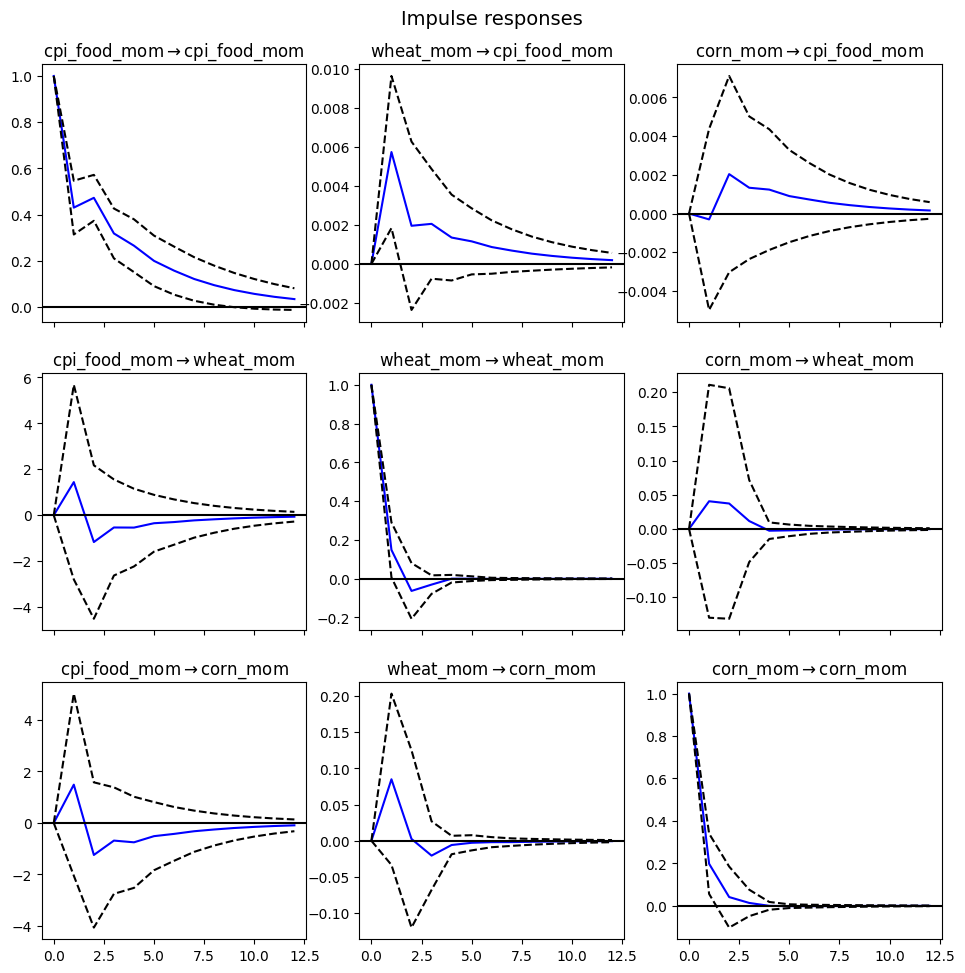

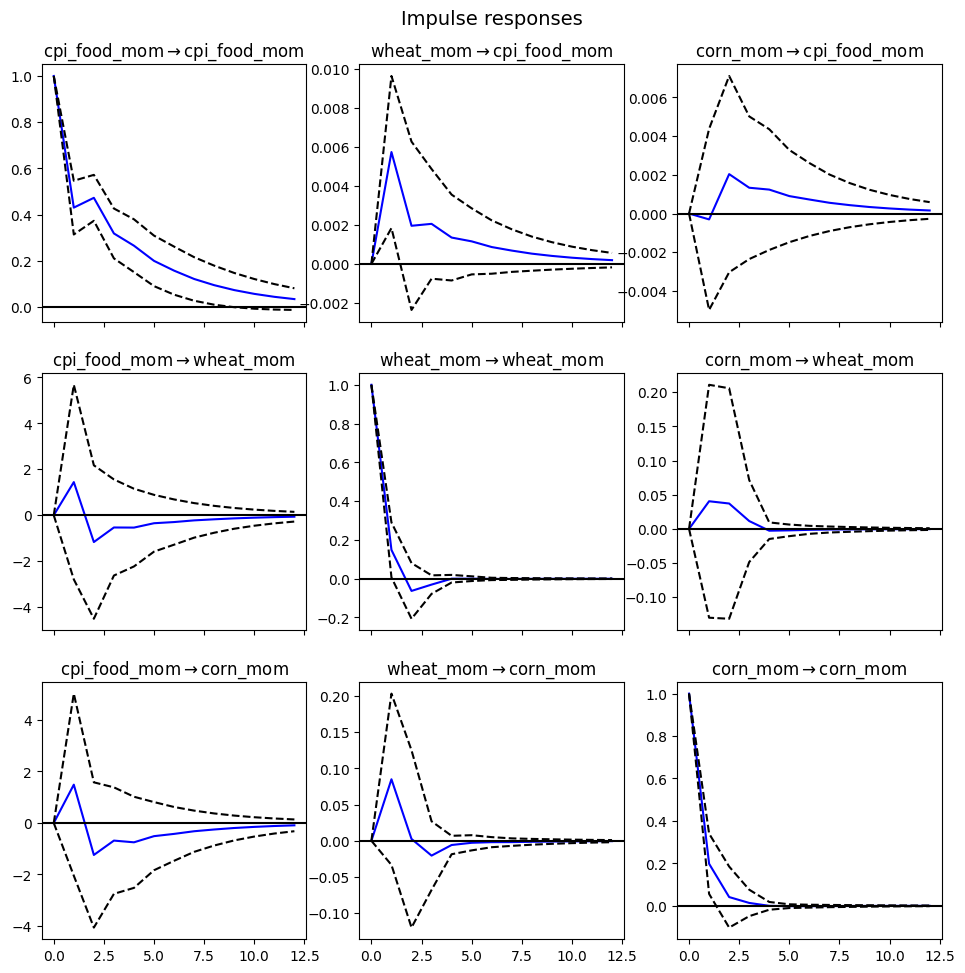

In [19]:
irf = results.irf(12)
irf.plot(orth=False)


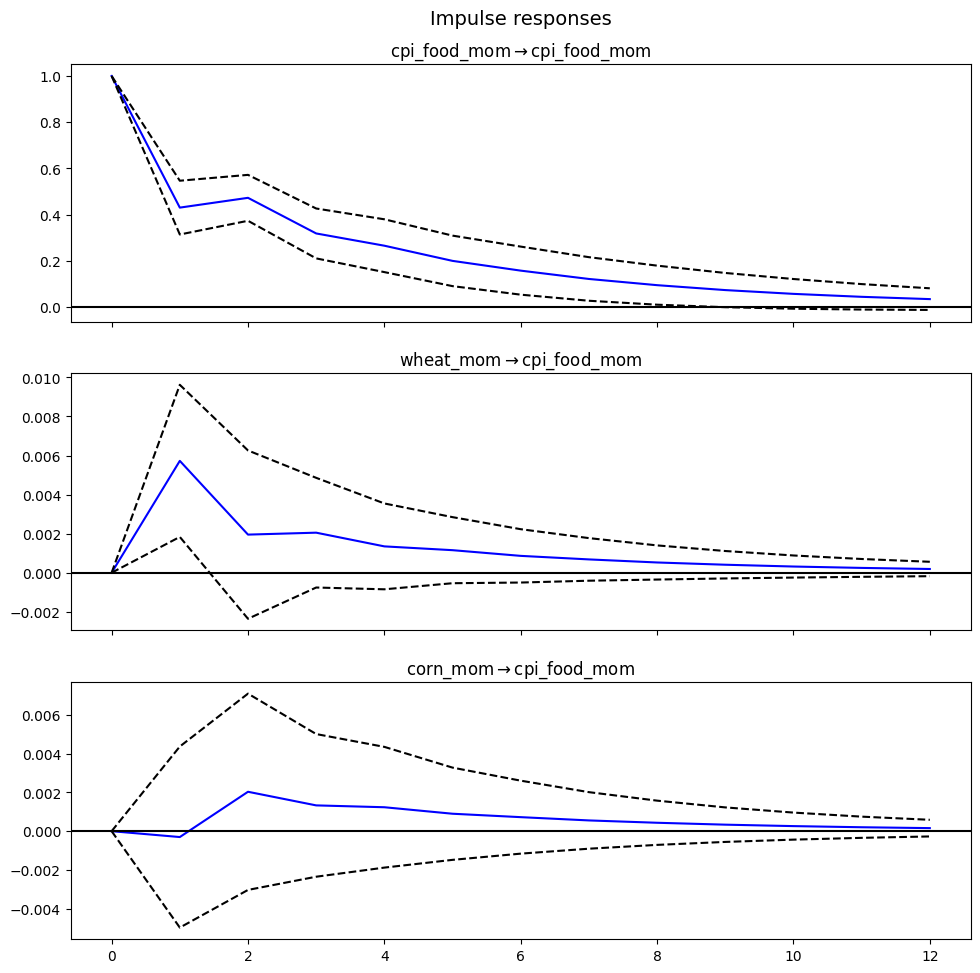

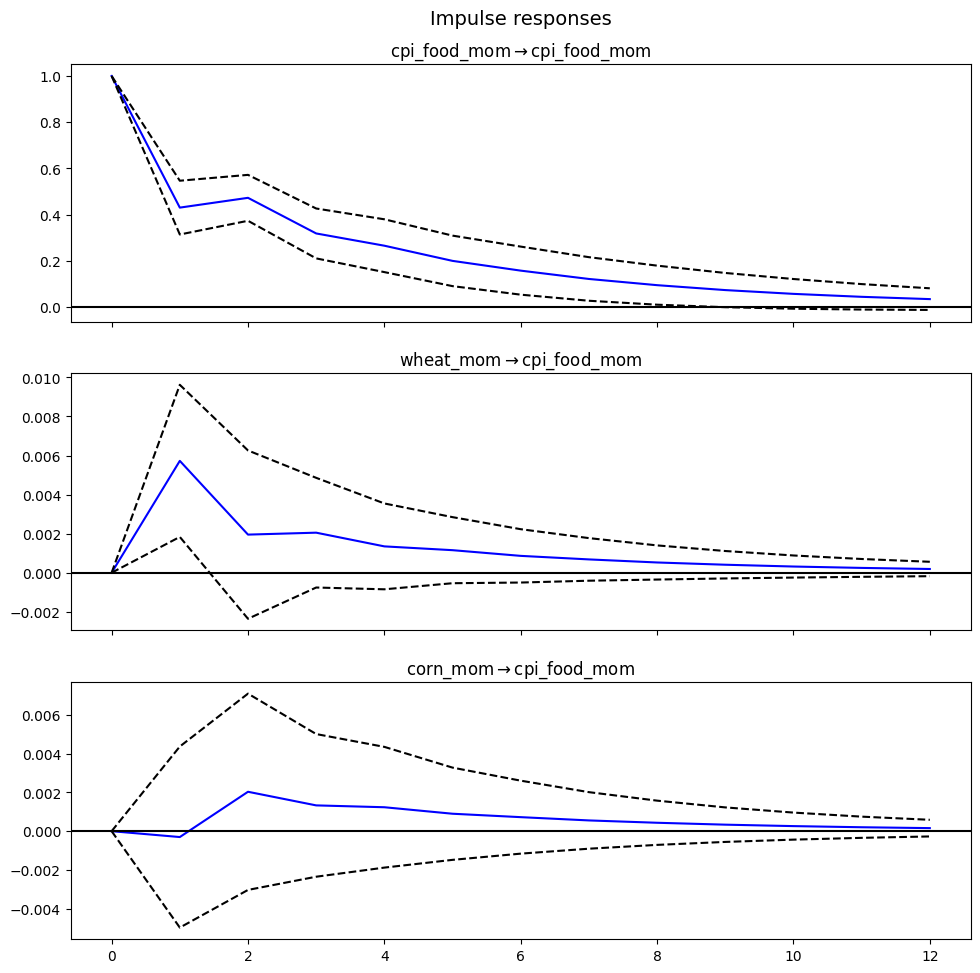

In [20]:
irf.plot(response="cpi_food_mom")


FEVD for cpi_food_mom
      cpi_food_mom  wheat_mom  corn_mom
0         1.000000   0.000000  0.000000
1         0.966160   0.033790  0.000049
2         0.962367   0.035721  0.001912
3         0.958410   0.039071  0.002520
4         0.956822   0.040163  0.003015
5         0.955725   0.041022  0.003253
6         0.955137   0.041460  0.003403
7         0.954778   0.041733  0.003489
8         0.954568   0.041891  0.003540
9         0.954442   0.041987  0.003571
10        0.954366   0.042044  0.003590
11        0.954320   0.042079  0.003601

FEVD for wheat_mom
      cpi_food_mom  wheat_mom  corn_mom
0         0.000046   0.999954  0.000000
1         0.001523   0.997689  0.000788
2         0.002461   0.996091  0.001448
3         0.002657   0.995833  0.001510
4         0.002869   0.995619  0.001513
5         0.002957   0.995528  0.001515
6         0.003021   0.995463  0.001516
7         0.003058   0.995426  0.001516
8         0.003081   0.995403  0.001516
9         0.003094   0.995389  0.00151

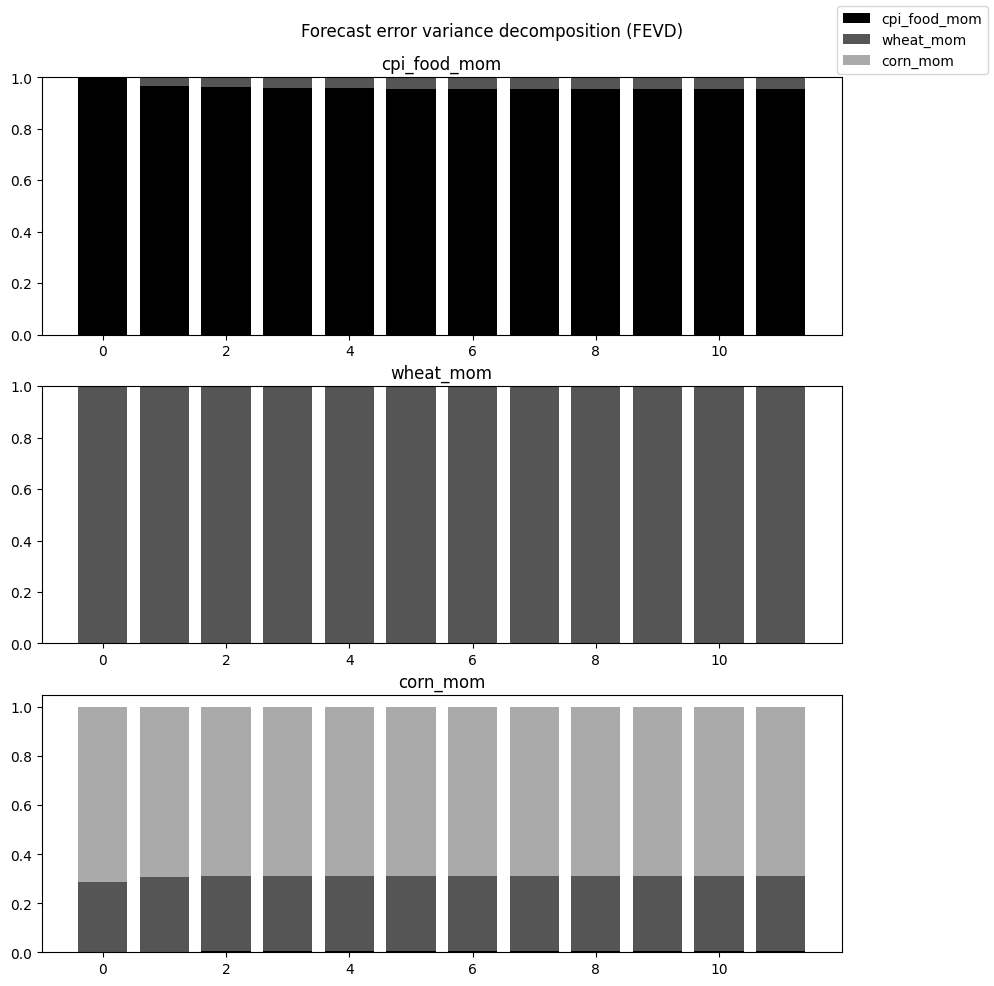

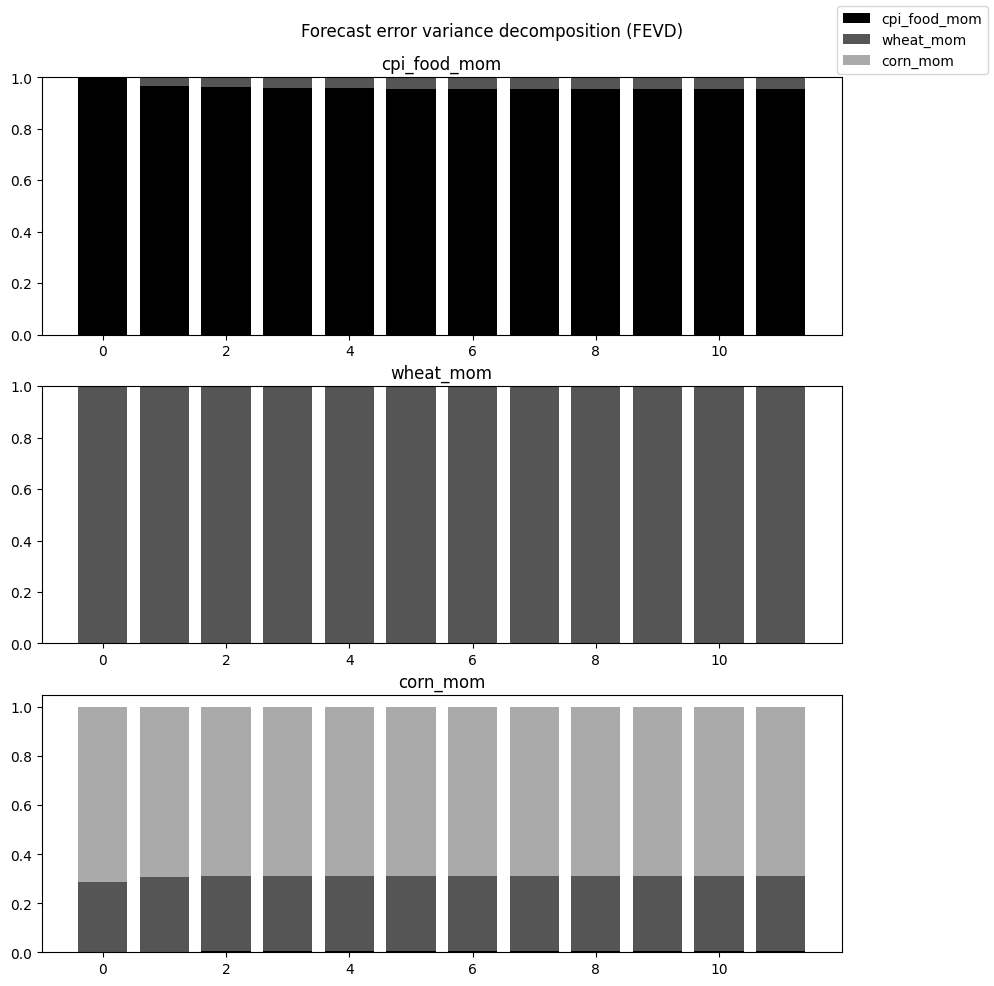

In [21]:
fevd = results.fevd(12)
fevd.summary()
fevd.plot()


In [22]:
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,4.651,4.692,104.7,4.667
1,4.138,4.302*,62.69,4.204*
2,4.102,4.388,60.45,4.217
3,4.082,4.491,59.28,4.246
4,4.051,4.583,57.49,4.265
5,4.027*,4.681,56.12*,4.290
6,4.035,4.811,56.56,4.347
7,4.047,4.945,57.27,4.408
8,4.076,5.097,58.99,4.486
9,4.086,5.230,59.62,4.545


In [23]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Feb, 2026
Time:                     22:47:00
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    4.36627
Nobs:                     272.000    HQIC:                   4.19964
Log likelihood:          -1692.81    FPE:                    59.6153
AIC:                      4.08788    Det(Omega_mle):         55.2398
--------------------------------------------------------------------
Results for equation cpi_food_mom
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.069066         0.017498            3.947           0.000
L1.cpi_food_mom         0.430433         0.059351            7.252           0.000
L1.wheat_mom            0.005726         0.00

In [24]:
results.is_stable(verbose=True)


Eigenvalues of VAR(1) rep
0.7769675216626162
0.3642186482301275
0.21534775911757836
0.008306291983789143
0.29182860583106723
0.29182860583106723


np.True_

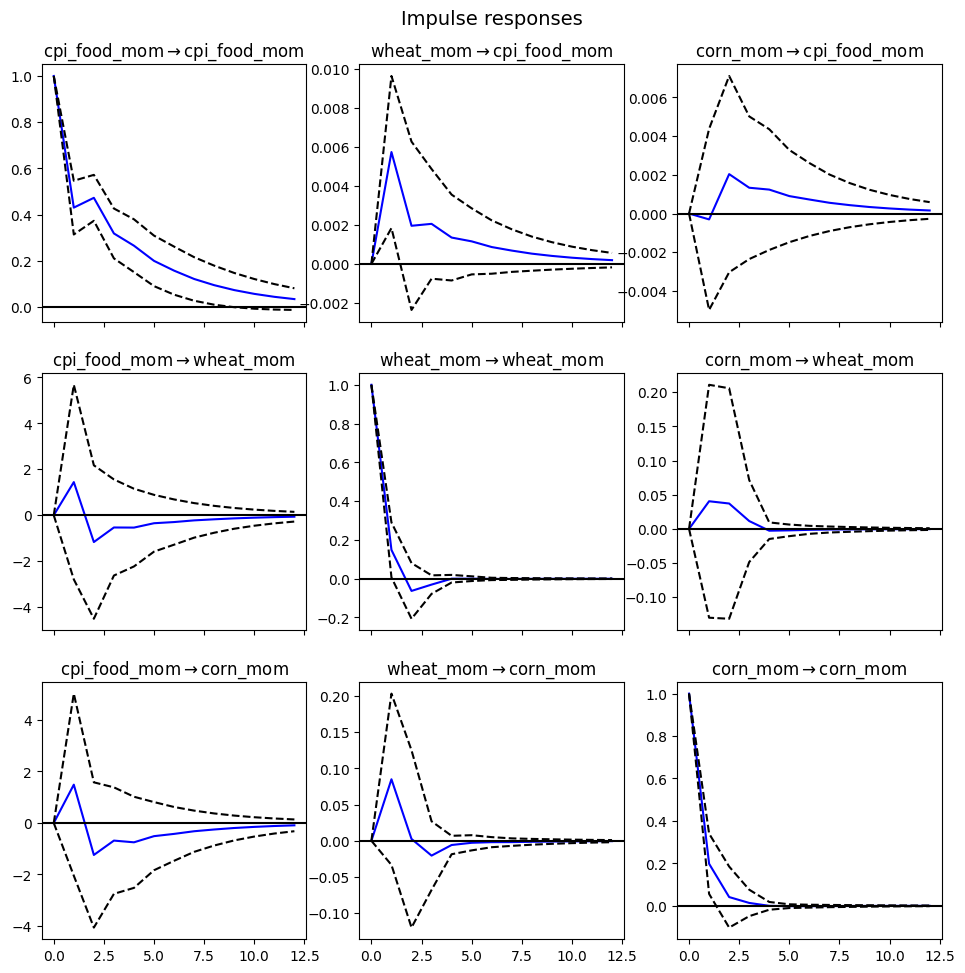

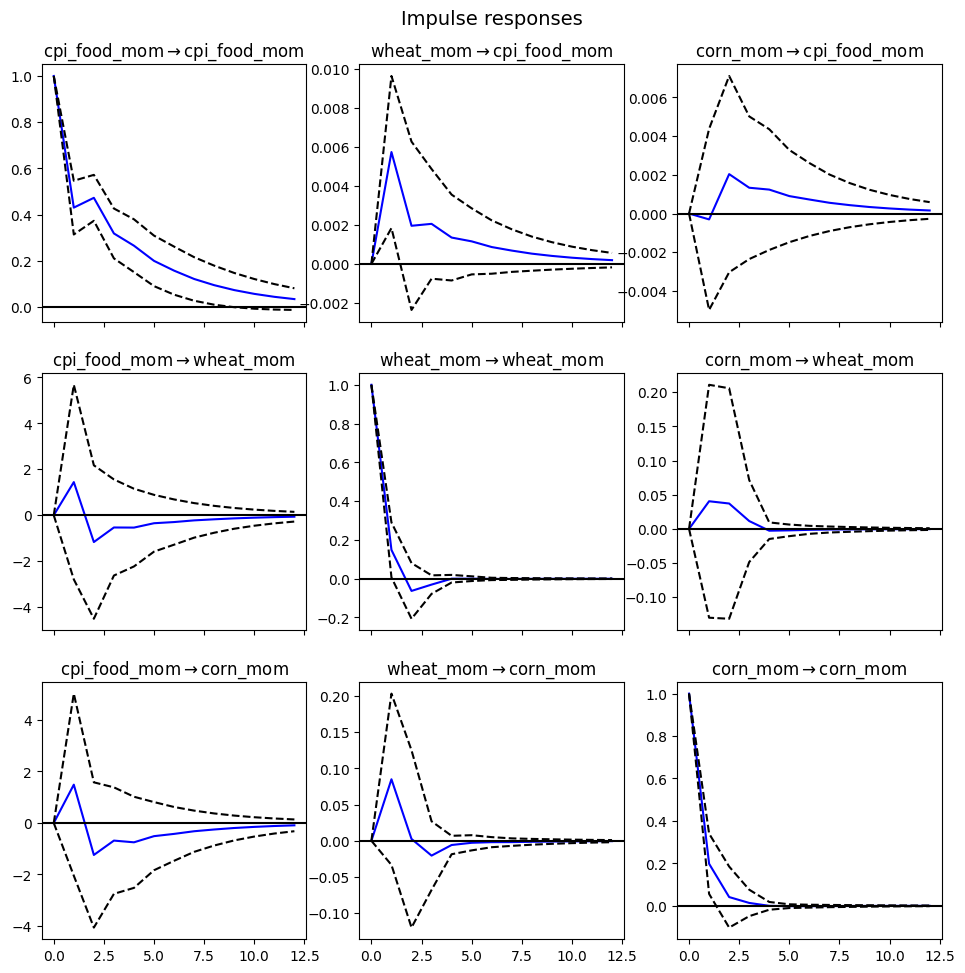

In [25]:
irf = results.irf(12)
irf.plot(orth=False)


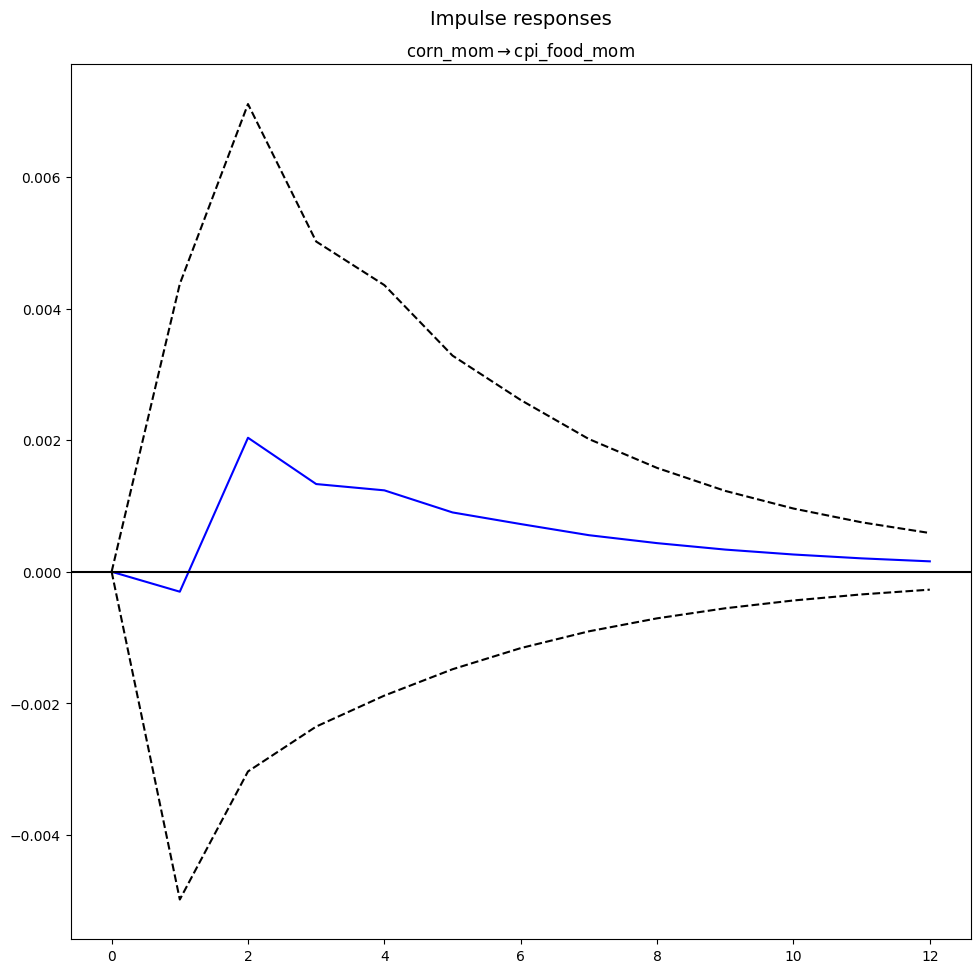

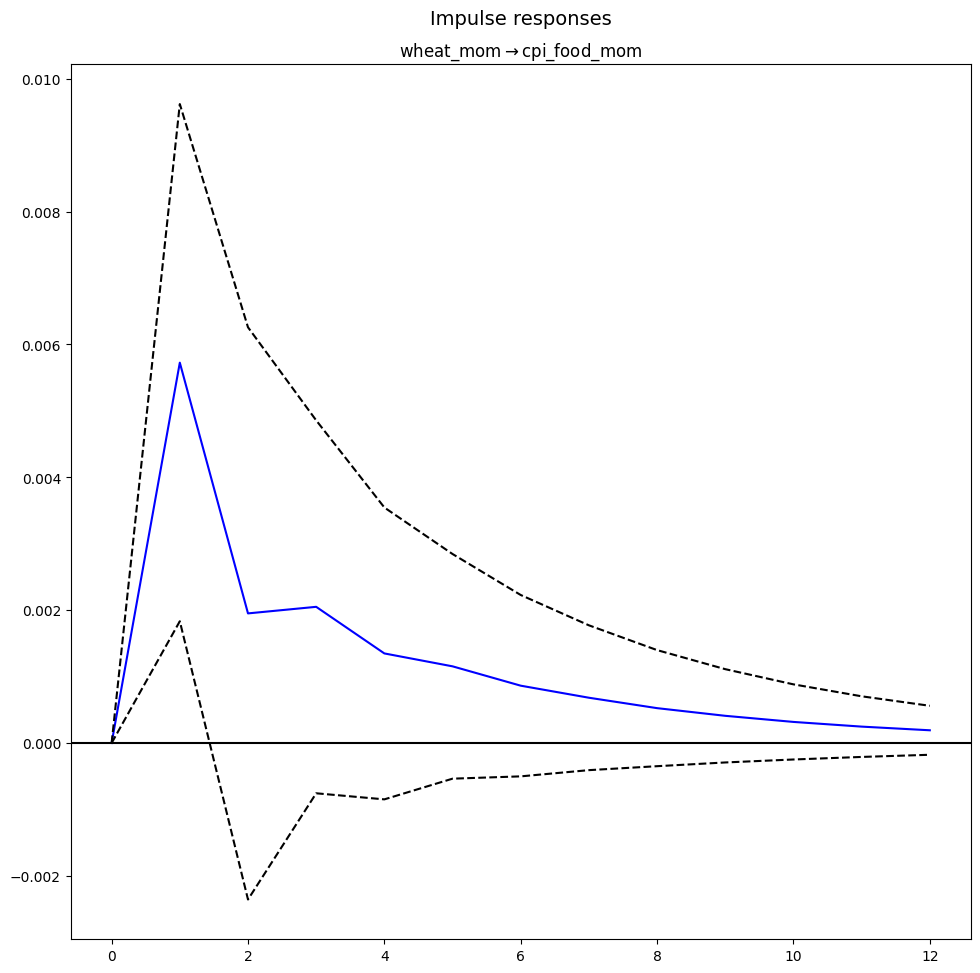

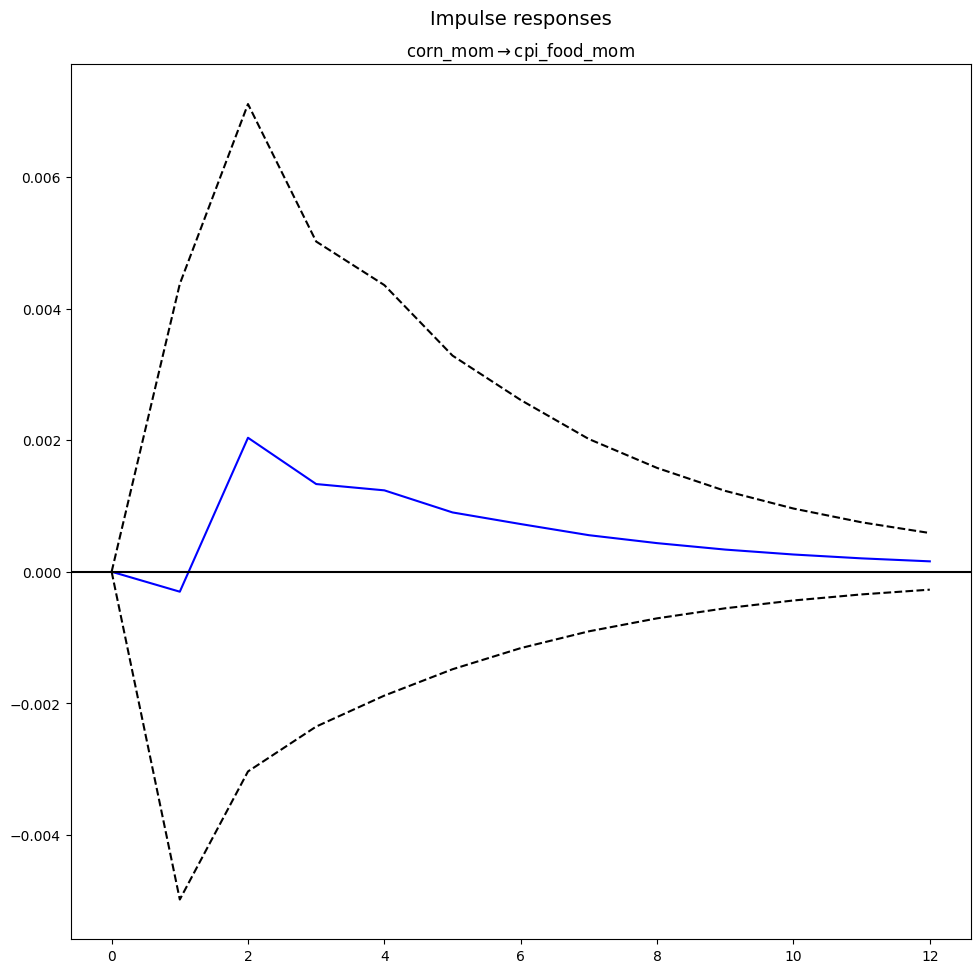

In [26]:
irf.plot(response="cpi_food_mom", impulse="wheat_mom")
irf.plot(response="cpi_food_mom", impulse="corn_mom")
